In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-ss/data_fold0.zip

In [3]:
ls

__notebook__.ipynb  data_fold0/


In [4]:
IMG_DIR = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'

In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 16
EPOCHS = 100

SAMPLE = None
CONDITIONS = ['Left Subarticular Stenosis', 'Right Subarticular Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'

In [6]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [7]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [8]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [9]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [10]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found ' + lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)

In [11]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [12]:
label_df = {'study_id': [], 'condition': [], 'level': [], 'label': []}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [13]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [14]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id == study_id) & (label_df.series_id == series_id) &
                        (label_df.instance_number == instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id == study_id)]
    else:
        return label_df[(train_xy.study_id == study_id) & (label_df.series_id == series_id)]

In [15]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
    image = np.stack([image] * 3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [16]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [17]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f'{get_accronym(row['condition'])}_{row['level']}'
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255, 255, 0) 
    elif row['label'] == 'Severe':
        color = (255, 0, 0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
20564,1839242409,Right Neural Foraminal Narrowing,L3/L4,Moderate,3,3211434109,7,285.515294,217.148235,Sagittal T1
20565,1839242409,Right Neural Foraminal Narrowing,L4/L5,Normal/Mild,3,3211434109,7,293.345882,255.698824,Sagittal T1


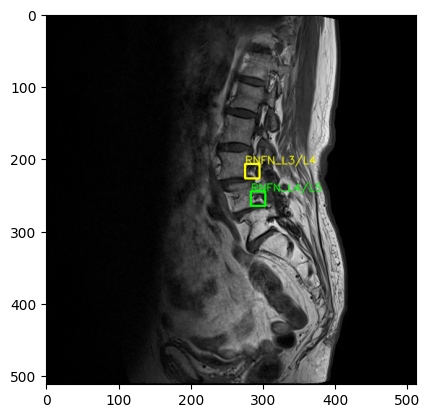

In [18]:
plt.imshow(img)
plt.show()

In [19]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
    image = np.stack([image] * 3, axis=-1).astype('uint8')
    return image

In [20]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [21]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f'{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}'
            label2id[cls_] = i
            id2label[i] = cls_
            i += 1

In [22]:
id2label

{0: 'left_subarticular_stenosis_l1_l2_normal/mild',
 1: 'left_subarticular_stenosis_l1_l2_moderate',
 2: 'left_subarticular_stenosis_l1_l2_severe',
 3: 'left_subarticular_stenosis_l2_l3_normal/mild',
 4: 'left_subarticular_stenosis_l2_l3_moderate',
 5: 'left_subarticular_stenosis_l2_l3_severe',
 6: 'left_subarticular_stenosis_l3_l4_normal/mild',
 7: 'left_subarticular_stenosis_l3_l4_moderate',
 8: 'left_subarticular_stenosis_l3_l4_severe',
 9: 'left_subarticular_stenosis_l4_l5_normal/mild',
 10: 'left_subarticular_stenosis_l4_l5_moderate',
 11: 'left_subarticular_stenosis_l4_l5_severe',
 12: 'left_subarticular_stenosis_l5_s1_normal/mild',
 13: 'left_subarticular_stenosis_l5_s1_moderate',
 14: 'left_subarticular_stenosis_l5_s1_severe',
 15: 'right_subarticular_stenosis_l1_l2_normal/mild',
 16: 'right_subarticular_stenosis_l1_l2_moderate',
 17: 'right_subarticular_stenosis_l1_l2_severe',
 18: 'right_subarticular_stenosis_l2_l3_normal/mild',
 19: 'right_subarticular_stenosis_l2_l3_moderat

In [23]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

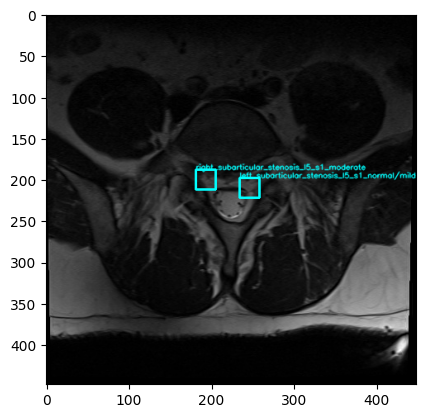

In [24]:
_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name + '.jpg')).copy()
H, W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name + '.txt')).reshape(-1, 5)

for _cls, x, y, w, h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x - w / 2)
    x2 = int(x + w / 2)
    y1 = int(y - h / 2)
    y2 = int(y + h / 2)
    label = id2label[_cls]
    
    c = (0, 255, 255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [25]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: left_subarticular_stenosis_l1_l2_normal/mild
1: left_subarticular_stenosis_l1_l2_moderate
2: left_subarticular_stenosis_l1_l2_severe
3: left_subarticular_stenosis_l2_l3_normal/mild
4: left_subarticular_stenosis_l2_l3_moderate
5: left_subarticular_stenosis_l2_l3_severe
6: left_subarticular_stenosis_l3_l4_normal/mild
7: left_subarticular_stenosis_l3_l4_moderate
8: left_subarticular_stenosis_l3_l4_severe
9: left_subarticular_stenosis_l4_l5_normal/mild
10: left_subarticular_stenosis_l4_l5_moderate
11: left_subarticular_stenosis_l4_l5_severe
12: left_subarticular_stenosis_l5_s1_normal/mild
13: left_subarticular_stenosis_l5_s1_moderate
14: left_subarticular_stenosis_l5_s1_severe
15: right_subarticular_stenosis_l1_l2_normal/mild
16: right_subarticular_stenosis_l1_l2_moderate
17: right_subarticular_stenosis_l1_l2_severe
18: right_subarticular_stenosis_l2_l3_normal/mild
19: right_subarticular_stenosis_l2_l3_moderate
20: right_subarticular_stenosis_l2_l3_severe
21: right_subarticular_stenosis

In [26]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [27]:
import os
HOME = os.getcwd()

In [28]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!ls -lh {HOME}/weights

total 123M
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [29]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0
train: images/train  
val: images/val 
test: images/val 

names:
    0: left_subarticular_stenosis_l1_l2_normal/mild
    1: left_subarticular_stenosis_l1_l2_moderate
    2: left_subarticular_stenosis_l1_l2_severe
    3: left_subarticular_stenosis_l2_l3_normal/mild
    4: left_subarticular_stenosis_l2_l3_moderate
    5: left_subarticular_stenosis_l2_l3_severe
    6: left_subarticular_stenosis_l3_l4_normal/mild
    7: left_subarticular_stenosis_l3_l4_moderate
    8: left_subarticular_stenosis_l3_l4_severe
    9: left_subarticular_stenosis_l4_l5_normal/mild
    10: left_subarticular_stenosis_l4_l5_moderate
    11: left_subarticular_stenosis_l4_l5_severe
    12: left_subarticular_stenosis_l5_s1_normal/mild
    13: left_subarticular_stenosis_l5_s1_moderate
    14: left_subarticular_stenosis_l5_s1_severe
    15: right_subarticular_stenosis_l1_l2_normal/mild
    16: right_subarticular_stenosis_l1_l2_moderate
    17: right_subarticular_stenosis_l1_l2_severe
    18: right_subarticular_stenosis_l2_l3_normal/mild
    19: right_subarticular_stenosis_l2_l3_moderate
    20: right_subarticular_stenosis_l2_l3_severe
    21: right_subarticular_stenosis_l3_l4_normal/mild
    22: right_subarticular_stenosis_l3_l4_moderate
    23: right_subarticular_stenosis_l3_l4_severe
    24: right_subarticular_stenosis_l4_l5_normal/mild
    25: right_subarticular_stenosis_l4_l5_moderate
    26: right_subarticular_stenosis_l4_l5_severe
    27: right_subarticular_stenosis_l5_s1_normal/mild
    28: right_subarticular_stenosis_l5_s1_moderate
    29: right_subarticular_stenosis_l5_s1_severe
  

Writing yolo_scs.yaml


In [30]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

secret_value_0 = 'bruh'
wandb.login(key=secret_value_0)

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
wandb.init(
    project='lsdc_yolov10x',
    group=';'.join(CONDITIONS)
)

wandb: Currently logged in as: lightsource- (lightsource-unk). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240924_203327-xb1d8gvh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run upbeat-aardvark-6
wandb: ⭐️ View project at https://wandb.ai/lightsource-unk/lsdc_yolov10x
wandb: 🚀 View run at https://wandb.ai/lightsource-unk/lsdc_yolov10x/runs/xb1d8gvh


In [32]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10x.pt')
add_wandb_callback(model, enable_model_checkpointing=True)

model.train(
    project='lsdc_yolov10', 
    data='yolo_scs.yaml', 
    epochs=EPOCHS, 
    imgsz=OD_INPUT_SIZE, 
    batch=BATCH_SIZE, 
    optimizer='AdamW',
    seed=52,
    cos_lr=True,
    device=[0, 1],
#     box=2.5,
#     cls=4.5,
#     dfl=2.5,
#     dropout=0.05
)

wandb.finish()

New https://pypi.org/project/ultralytics/8.2.100 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10x.pt, data=yolo_scs.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=384, save=True, save_period=-1, val_period=1, cache=False, device=[0, 1], workers=8, project=lsdc_yolov10, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=52, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vi

100%|██████████| 755k/755k [00:00<00:00, 14.6MB/s]
2024-09-24 20:33:48,091	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-24 20:33:48,926	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-24 20:33:51.939839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 20:33:51.939937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 20:33:52.118170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1    213120  ultralytics.nn.modules.block.SCDown          [320, 640, 3, 2]              
  6                  -1  6   4604160  ultralytics.nn.modules.block.C2fCIB          [640, 640, 6, True]           
  7                  -1  1    417920  ultralytic

2024-09-24 20:34:12.998000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 20:34:12.998078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 20:34:12.999923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir lsdc_yolov10/train', view at http://localhost:6006/


wandb: Currently logged in as: lightsource- (lightsource-unk). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240924_203416-bq0n6anj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/lightsource-unk/lsdc_yolov10
wandb: 🚀 View run at https://wandb.ai/lightsource-unk/lsdc_yolov10/runs/bq0n6anj


Overriding model.yaml nc=80 with nc=30
Transferred 1123/1135 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 75.0MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 11016 images, 5 backgrounds, 0 corrupt: 100%|██████████| 11016/11016 [00:08<00:00, 1243.81it/s]


train: New cache created: /kaggle/working/data_fold0/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 2726 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2726/2726 [00:02<00:00, 1176.85it/s]


val: New cache created: /kaggle/working/data_fold0/labels/val.cache
Plotting labels to lsdc_yolov10/train/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.0005), 197 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov10/train
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      1/100      4.96G        2.3      3.195      1.101      2.213      3.344      1.025         12        384: 100%|██████████| 689/689 [03:55<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:18<00:00,  2.19it/s]


                   all       2726       3856      0.498      0.177     0.0558     0.0198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      2/100      5.28G      2.034      2.571      1.027      1.939       2.71     0.9595          7        384: 100%|██████████| 689/689 [03:36<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.24it/s]


                   all       2726       3856       0.59      0.203     0.0783     0.0353

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      3/100      5.29G      1.911      2.392      1.002      1.806      2.546     0.9362          9        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856       0.31      0.241     0.0989      0.044

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      4/100      5.28G      1.832       2.32     0.9852      1.712      2.456     0.9189          4        384: 100%|██████████| 689/689 [03:26<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.482      0.247      0.125     0.0569

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      5/100      5.28G      1.774      2.224     0.9724      1.676      2.368     0.9144          7        384: 100%|██████████| 689/689 [03:26<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.511      0.258       0.14     0.0667

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      6/100      5.28G      1.765      2.192     0.9645      1.638      2.336      0.901          5        384: 100%|██████████| 689/689 [03:27<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.298      0.262      0.139     0.0675

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      7/100      5.28G      1.741      2.117      0.968      1.618      2.269     0.9035          5        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.226      0.371      0.166     0.0772

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      8/100      5.27G      1.722      2.096     0.9613      1.604      2.246     0.8978          9        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.332      0.323      0.207      0.101

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      9/100      5.28G      1.713      2.028     0.9583      1.581      2.182     0.8953         11        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.391      0.333      0.214     0.0995

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     10/100      5.28G      1.699      1.992      0.956      1.563      2.163     0.8928         10        384: 100%|██████████| 689/689 [03:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.311      0.345        0.2     0.0968

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     11/100      5.28G      1.684      1.952     0.9542      1.548      2.105     0.8897          9        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856       0.37      0.329      0.226      0.112

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     12/100      5.27G      1.683      1.917     0.9514      1.549      2.069     0.8886          4        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.399      0.378      0.246      0.121

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     13/100      5.28G      1.675      1.941     0.9554      1.534       2.09     0.8899         11        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.363      0.331      0.217      0.107

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     14/100      5.28G       1.68      1.909     0.9547      1.547      2.066     0.8904          8        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.398      0.365      0.266      0.129

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     15/100      5.28G      1.648      1.879     0.9491      1.518      2.023     0.8864          7        384: 100%|██████████| 689/689 [03:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.325      0.357      0.253      0.121

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     16/100      5.27G       1.65      1.854     0.9469       1.53      1.993      0.887          6        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.372      0.364      0.236      0.116

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     17/100      5.28G      1.641      1.829      0.944      1.528      1.981     0.8865          4        384: 100%|██████████| 689/689 [03:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.258      0.394      0.225      0.112

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     18/100      5.28G       1.65      1.818     0.9487      1.509      1.971     0.8858          5        384: 100%|██████████| 689/689 [03:27<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.283      0.413      0.265      0.132

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     19/100      5.28G      1.636      1.781     0.9446      1.499      1.937     0.8843         10        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.391      0.412      0.301      0.151

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     20/100      5.27G      1.641      1.782       0.95      1.518      1.926     0.8907         10        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.324      0.419      0.319       0.16

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     21/100      5.28G      1.627      1.741     0.9454      1.485      1.897      0.882          7        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.337      0.436      0.306      0.153

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     22/100      5.29G      1.624      1.732     0.9426       1.48      1.876     0.8815         12        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.347      0.437      0.323      0.156

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     23/100      5.28G        1.6      1.701     0.9407       1.48      1.838     0.8821         13        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.406      0.409      0.328      0.165

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     24/100      5.27G      1.617      1.666     0.9419      1.484      1.829     0.8826         12        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.359      0.495      0.362      0.185

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     25/100      5.28G      1.615      1.662     0.9408       1.49      1.799     0.8827          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.326       0.51      0.372      0.185

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     26/100      5.29G       1.59      1.646     0.9349      1.476      1.787     0.8812          7        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.407      0.422       0.34      0.173

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     27/100      5.28G      1.604      1.647     0.9411       1.46      1.799     0.8781          6        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.389      0.464      0.344      0.176

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     28/100      5.27G      1.595      1.651     0.9386      1.467      1.789     0.8812          9        384: 100%|██████████| 689/689 [03:27<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.346      0.509       0.36       0.18

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     29/100      5.28G      1.596      1.645     0.9381      1.458      1.798     0.8786         13        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.366      0.485      0.346      0.176

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     30/100      5.28G      1.566      1.588      0.933      1.429      1.755     0.8751          9        384: 100%|██████████| 689/689 [03:28<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.375      0.477      0.365      0.185

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     31/100      5.28G        1.6       1.61     0.9431      1.472      1.754     0.8829          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.382      0.497      0.375      0.192

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     32/100      5.27G      1.592      1.608     0.9334      1.452      1.748     0.8753          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.379      0.484      0.375      0.192

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     33/100      5.28G      1.578      1.593      0.935      1.442      1.744     0.8769          7        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.428      0.479      0.367      0.189

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     34/100      5.29G      1.577      1.582     0.9333      1.441       1.74     0.8737         10        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856       0.41      0.478      0.371      0.188

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     35/100      5.28G      1.579      1.591     0.9349      1.449      1.736     0.8773          9        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.362      0.508      0.371      0.189

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     36/100      5.27G      1.576       1.56     0.9319      1.442      1.713     0.8738         11        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.378      0.479      0.369      0.189

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     37/100      5.28G      1.566      1.543     0.9312      1.441      1.696     0.8733         16        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.426      0.494       0.37      0.188

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     38/100      5.28G       1.56      1.555     0.9344      1.431      1.712      0.878          5        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.345      0.494      0.389      0.195

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     39/100      5.28G      1.561      1.572     0.9336      1.438      1.711     0.8768          3        384: 100%|██████████| 689/689 [03:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.343      0.502      0.384      0.194

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     40/100      5.27G      1.558       1.54     0.9317      1.445      1.691     0.8773          9        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.346      0.509      0.388      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     41/100      5.28G       1.56      1.541     0.9318      1.423      1.686     0.8728          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.388      0.489      0.385      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     42/100      5.29G      1.559      1.528     0.9299      1.427      1.682     0.8726         11        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.327      0.497       0.38      0.194

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     43/100      5.28G      1.535      1.519     0.9276      1.421      1.663     0.8737         10        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.348       0.52      0.375      0.192

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     44/100      5.27G      1.562      1.513     0.9318      1.431      1.653      0.873          7        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856       0.36      0.501      0.383      0.193

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     45/100      5.28G      1.551      1.508      0.928       1.42      1.648     0.8717          2        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.377      0.506      0.385      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     46/100      5.28G      1.526      1.502     0.9257       1.42      1.625      0.875          6        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.399      0.514      0.393        0.2

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     47/100      5.28G      1.532      1.478     0.9267      1.413      1.618     0.8739          6        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856        0.4        0.5      0.389      0.199

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     48/100      5.27G      1.528       1.49     0.9306      1.411      1.633     0.8752          4        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.403      0.498      0.388      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     49/100      5.28G      1.539      1.479     0.9285      1.402      1.623     0.8709          7        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.383      0.511      0.395        0.2

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     50/100      5.29G      1.525      1.472     0.9219      1.407      1.613     0.8678         10        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.414      0.501      0.395        0.2

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     51/100      5.27G      1.515      1.452     0.9234        1.4      1.597     0.8693          4        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.417      0.484      0.399      0.203

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     52/100      5.27G      1.516      1.476     0.9226      1.402      1.617     0.8679         11        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.376      0.526      0.402      0.204

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     53/100      5.28G      1.521       1.46     0.9245      1.391      1.609     0.8698         13        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.383      0.522      0.408      0.204

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     54/100      5.28G      1.514      1.435     0.9214      1.396       1.58     0.8664          4        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.388      0.529      0.407      0.204

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     55/100      5.28G      1.525      1.431     0.9216      1.399      1.579     0.8679         11        384: 100%|██████████| 689/689 [03:31<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.403      0.536       0.41      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     56/100      5.27G        1.5      1.424     0.9186      1.386      1.571     0.8667          9        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.378      0.531      0.408      0.203

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     57/100      5.28G      1.504      1.422       0.92      1.403      1.555     0.8713          8        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.393      0.517      0.407      0.203

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     58/100      5.29G        1.5      1.407     0.9212      1.375      1.556     0.8673          7        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.385      0.541      0.404      0.204

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     59/100      5.28G      1.501      1.408     0.9206      1.382      1.554     0.8675          9        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.365      0.539      0.405      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     60/100      5.27G      1.508      1.406      0.922      1.379      1.563     0.8669          5        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.394      0.529      0.405      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     61/100      5.28G      1.492      1.407     0.9175      1.378      1.544     0.8663         11        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.391      0.525      0.406      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     62/100      5.28G      1.481       1.39     0.9214      1.385      1.527     0.8719          5        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.384      0.532      0.406      0.206

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     63/100      5.28G      1.471      1.373     0.9172      1.367      1.525     0.8671          9        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.387      0.526      0.408      0.205

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     64/100      5.27G      1.488      1.387     0.9172      1.373       1.52      0.866          5        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.369      0.533        0.4        0.2

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     65/100      5.28G      1.467      1.372     0.9127      1.355      1.516     0.8636          7        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.375      0.541      0.394      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     66/100      5.29G      1.478      1.361     0.9211      1.365      1.518     0.8674          8        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.372      0.521        0.4      0.201

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     67/100      5.28G      1.458      1.359     0.9153      1.351      1.507     0.8659          6        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.379      0.521        0.4        0.2

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     68/100      5.27G       1.45      1.357     0.9125      1.355      1.493     0.8645          4        384: 100%|██████████| 689/689 [03:32<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.383      0.524      0.396      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     69/100      5.28G      1.454      1.349     0.9137      1.364      1.487     0.8668         10        384: 100%|██████████| 689/689 [03:31<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.392      0.537      0.395      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     70/100      5.28G      1.458      1.329     0.9148      1.365      1.469     0.8672         13        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.381       0.54      0.397      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     71/100      5.28G      1.459      1.337     0.9122      1.351      1.488     0.8645         13        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.385       0.54        0.4      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     72/100      5.27G      1.454      1.316     0.9144       1.35      1.474     0.8655          9        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.375      0.533      0.398      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     73/100      5.28G       1.46      1.326      0.916      1.353      1.473     0.8658          6        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.383      0.527      0.397      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     74/100      5.28G      1.442      1.309     0.9136      1.344      1.454     0.8659          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.383      0.528      0.395      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     75/100      5.28G      1.445      1.294     0.9124       1.33       1.45      0.863         10        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.369      0.534      0.394      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     76/100      5.27G      1.434       1.31     0.9095      1.353      1.456     0.8642         11        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.369      0.529      0.398      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     77/100      5.28G      1.435      1.313     0.9121      1.343      1.456      0.865          5        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.373      0.527      0.397      0.198

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     78/100      5.29G      1.428       1.29     0.9125      1.358      1.428     0.8686          9        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.363      0.526      0.392      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     79/100      5.28G      1.417       1.29     0.9089      1.334      1.435     0.8634          4        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856       0.36       0.53      0.392      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     80/100      5.27G      1.408       1.28     0.9087      1.325      1.429     0.8644          6        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856       0.36      0.535      0.391      0.195

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     81/100      5.28G      1.418       1.27     0.9113      1.343      1.418     0.8664         11        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.358      0.539      0.391      0.195

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     82/100      5.28G      1.412      1.279     0.9096      1.332      1.422     0.8641         10        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.366      0.538      0.397      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     83/100      5.28G      1.412      1.281     0.9077      1.332      1.431     0.8621          5        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.372      0.538      0.397      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     84/100      5.27G       1.39      1.274     0.9035      1.317      1.417     0.8608          8        384: 100%|██████████| 689/689 [03:31<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.367      0.543      0.397      0.195

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     85/100      5.28G      1.407      1.263     0.9063      1.327       1.41      0.863         15        384: 100%|██████████| 689/689 [03:32<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856       0.36      0.555        0.4      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     86/100      5.28G      1.411      1.277     0.9097      1.327      1.427     0.8626          5        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.358      0.553        0.4      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     87/100      5.28G      1.395      1.252     0.9029      1.318      1.398      0.861         11        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.357      0.556      0.399      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     88/100      5.27G      1.406      1.255     0.9046      1.309      1.402     0.8591          4        384: 100%|██████████| 689/689 [03:31<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.356      0.558      0.399      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     89/100      5.28G      1.404      1.277     0.9031      1.322      1.429     0.8598          6        384: 100%|██████████| 689/689 [03:30<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.355       0.56      0.399      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     90/100      5.28G      1.397      1.249     0.9045      1.325      1.388      0.861          8        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.357      0.561      0.398      0.196
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     91/100      5.28G      1.398      1.191     0.9369       1.29      1.315     0.8816          5        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.22it/s]


                   all       2726       3856      0.357      0.561      0.398      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     92/100      5.27G      1.385      1.179     0.9381      1.283      1.307     0.8836          5        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.21it/s]


                   all       2726       3856      0.356      0.562      0.398      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     93/100      5.28G      1.387      1.166     0.9338      1.284      1.287     0.8818          6        384: 100%|██████████| 689/689 [03:30<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.356      0.563      0.399      0.197

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     94/100      5.28G      1.381      1.155      0.938      1.274      1.296     0.8837          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.355      0.565      0.399      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     95/100      5.28G      1.382      1.172     0.9379      1.281      1.295     0.8835          5        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.355      0.565      0.398      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     96/100      5.27G      1.376      1.147      0.938      1.278      1.272     0.8856          5        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.355      0.562      0.398      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     97/100      5.28G      1.363      1.154     0.9327      1.268      1.283     0.8797          6        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.356      0.561      0.398      0.195

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     98/100      5.28G      1.363      1.154     0.9348      1.263      1.278     0.8819          6        384: 100%|██████████| 689/689 [03:29<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.354      0.563      0.397      0.195

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     99/100      5.28G      1.378      1.144     0.9357      1.275       1.27     0.8834          8        384: 100%|██████████| 689/689 [03:29<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:16<00:00,  2.23it/s]


                   all       2726       3856      0.355      0.563      0.398      0.196

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


    100/100      5.27G      1.369      1.147     0.9353       1.27      1.279     0.8833          5        384: 100%|██████████| 689/689 [03:28<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:17<00:00,  2.22it/s]


                   all       2726       3856      0.354      0.565      0.398      0.196

100 epochs completed in 8.100 hours.
Optimizer stripped from lsdc_yolov10/train/weights/last.pt, 64.2MB
Optimizer stripped from lsdc_yolov10/train/weights/best.pt, 64.2MB

Validating lsdc_yolov10/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                      CUDA:1 (Tesla T4, 15095MiB)
YOLOv10x summary (fused): 503 layers, 31641860 parameters, 0 gradients, 170.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 171/171 [01:14<00:00,  2.29it/s]


                   all       2726       3856      0.405      0.537      0.416      0.205
left_subarticular_stenosis_l1_l2_normal/mild       2726        349       0.46      0.868      0.616      0.296
left_subarticular_stenosis_l1_l2_moderate       2726         15       0.44      0.467      0.367      0.226
left_subarticular_stenosis_l1_l2_severe       2726          4          1          0      0.559      0.159
left_subarticular_stenosis_l2_l3_normal/mild       2726        316      0.432      0.848       0.58      0.302
left_subarticular_stenosis_l2_l3_moderate       2726         49      0.376      0.469      0.347      0.191
left_subarticular_stenosis_l2_l3_severe       2726         12      0.242      0.294      0.177     0.0896
left_subarticular_stenosis_l3_l4_normal/mild       2726        254      0.409      0.803      0.582      0.316
left_subarticular_stenosis_l3_l4_moderate       2726        100      0.381      0.586      0.427      0.247
left_subarticular_stenosis_l3_l4_severe   

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                  lr/pg1 ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:                  lr/pg2 ▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wandb:        metrics/mAP50(B) ▁▂▃▄▄▄▄▅▆▆▇▇▇▇▇▇▇▇██████████████████████
wandb:     metrics/mAP50-95(B) ▁▂▃▄▄▄▅▅▆▆▇▇▇▇▇██▇██████████████████████
wandb:    metrics/precision(B) █▂▁▃▄▄▄▁▃▅▅▃▄▅▄▃▄▄▅▄▅▄▄▄▅▄▄▅▄▄▄▃▄▄▃▃▃▃▃▅
wandb:       metrics/recall(B) ▁▂▃▄▄▄▄▅▆��▅▇▇▆▆▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:            train/box_om █▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:            train/box_oo █▅▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:            train/cls_om █▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:            train/cls_oo █▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁

right_subarticular_stenosis_l2_l3_normal/mild


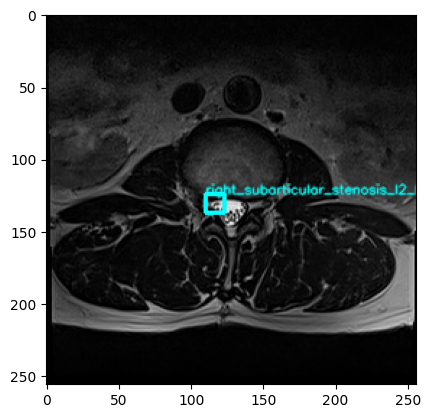

In [33]:
_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name + '.jpg')

im = plt.imread(path).copy()
H, W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name + '.txt')).reshape(-1, 5)

for _cls, x, y, w, h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x - w / 2)
    x2 = int(x + w / 2)
    y1 = int(y - h / 2)
    y2 = int(y + h / 2)
    label = id2label[_cls]
    print(label)
    
    c = (0, 255, 255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [34]:
model = YOLOv10(glob.glob('lsdc_yolov10/*/weights/best.pt')[0])

out = model.predict([path], save=True, conf=0.2)

wandb.finish()


0: 384x384 1 right_subarticular_stenosis_l2_l3_normal/mild, 36.3ms
Speed: 3.1ms preprocess, 36.3ms inference, 48.9ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


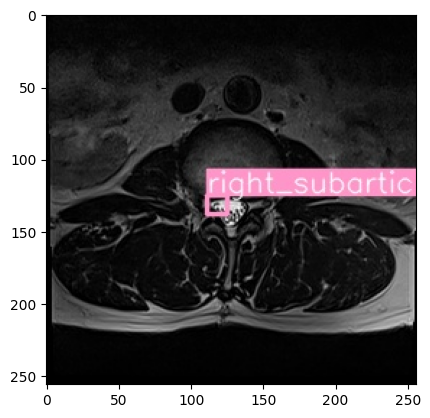

In [35]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)